<a href="https://colab.research.google.com/github/maskmo/personal-projects/blob/main/Fat_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
import tensorflow as tf
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [92]:
# Hyperparameters
target_height = 224
target_width = 224
batch_size = 5

# Step 1: Load Data

# Load CSV file (no images just path names and labels)
csv_path = "/content/gdrive/MyDrive/training/train_data.csv"
df = pd.read_csv(csv_path)

# Convert to dictionary: {"image1.jpg": label, ...}
label_dict = dict(zip(df['x:image'], df['y']))

# Define path to image directory
image_dir = pathlib.Path("/content/gdrive/MyDrive/training/photos")

# Correct path name (from/photos/photos to /photos)
df['x:image'] = df['x:image'].apply(lambda x: Path(x).name)

# Load file paths and corresponding labels from the dictionary above
filepaths = [str(image_dir / fname) for fname in df['x:image']]
labels = df['y'].tolist()

# Create a tensorflow dataset from them
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

# Step 2: Preprocess function
def process_image_with_label(filepath, label):
    image = tf.io.read_file(filepath)                                     # Load filepaths
    image = tf.image.decode_png(image, channels=3)                        # Decode pngs into pixel arrays
    image = tf.image.resize_with_pad(image, target_height, target_width)  # Resize the images to be uniform pixel dimesions using padding for smaller photos
    image = tf.cast(image, tf.float32) / 255.0                            # Normalize dimensions from 0-1
    return image, label

In [93]:
# Step 3: Map preprocessing to dataset
dataset = dataset.map(process_image_with_label, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch so we don't have to later
dataset = dataset.shuffle(buffer_size=len(filepaths))
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [94]:
# Used to verify paths when they weren't loading properly (closed)

for path in filepaths[:5]:
    print(path, "->", tf.io.gfile.exists(path))

/content/gdrive/MyDrive/training/photos/1.png -> True
/content/gdrive/MyDrive/training/photos/2.png -> True
/content/gdrive/MyDrive/training/photos/3.png -> True
/content/gdrive/MyDrive/training/photos/4.png -> True
/content/gdrive/MyDrive/training/photos/5.png -> True


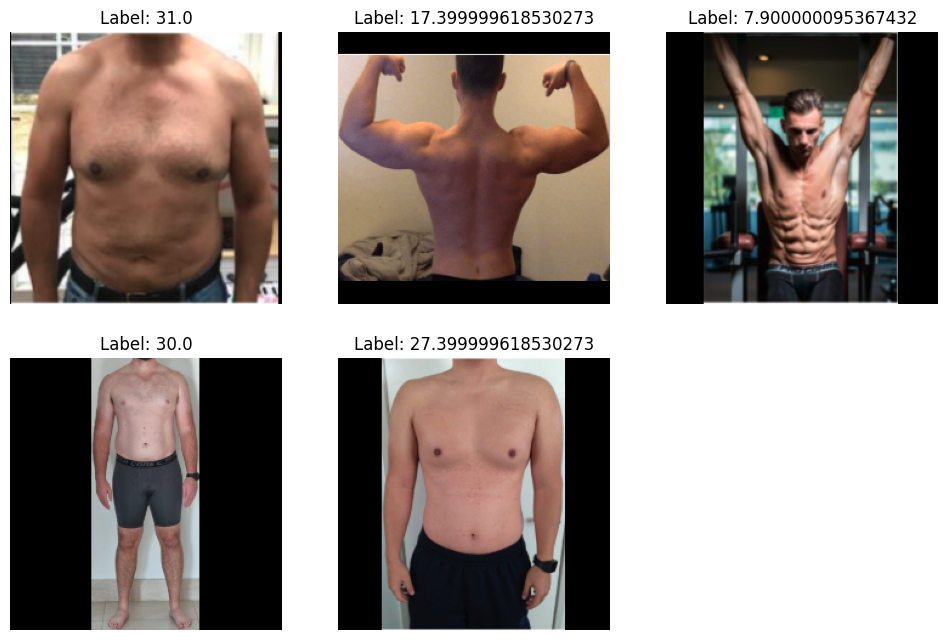

In [95]:
# Take one batch from the dataset
for images, labels in dataset.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(min(9, images.shape[0])):      # display up to 9 images (doesn't matter we're loading batches of 5 due to low amount of data)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()                                    #Display images with labels

In [149]:
# CNN for feature extraction and simplification
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3), pooling='max') # include_top = False means no bottom layer which will be the decision tree
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten()
])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1280)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [192]:
# Take the output from the CNN Model and the corresponding labels and upload them to arrays for feature extratction
features = []
true_labels = []

for images, labels in dataset:
    feats = model(images, training=False).numpy()
    features.append(feats)
    true_labels.append(labels.numpy())

In [193]:
# Train decision tree on data from CNN

X = np.vstack(features)
y = np.concatenate(true_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=41
)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mean squared error and R^2 score for validation

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 123.1989
R² Score: -1.5175


In [194]:
features = []
true_labels = []
original_images = []

for images, labels in dataset:
    feats = model(images, training=False).numpy()
    features.append(feats)
    true_labels.append(labels.numpy())
    original_images.append(images.numpy())

In [195]:
X = np.vstack(features)
y = np.concatenate(true_labels)
imgs = np.vstack(original_images)  # shape: [num_samples, height, width, channels]

In [203]:
X_train, X_test, y_train, y_test, imgs_train, imgs_test = train_test_split(
    X, y, imgs, test_size=0.8, random_state=41
)

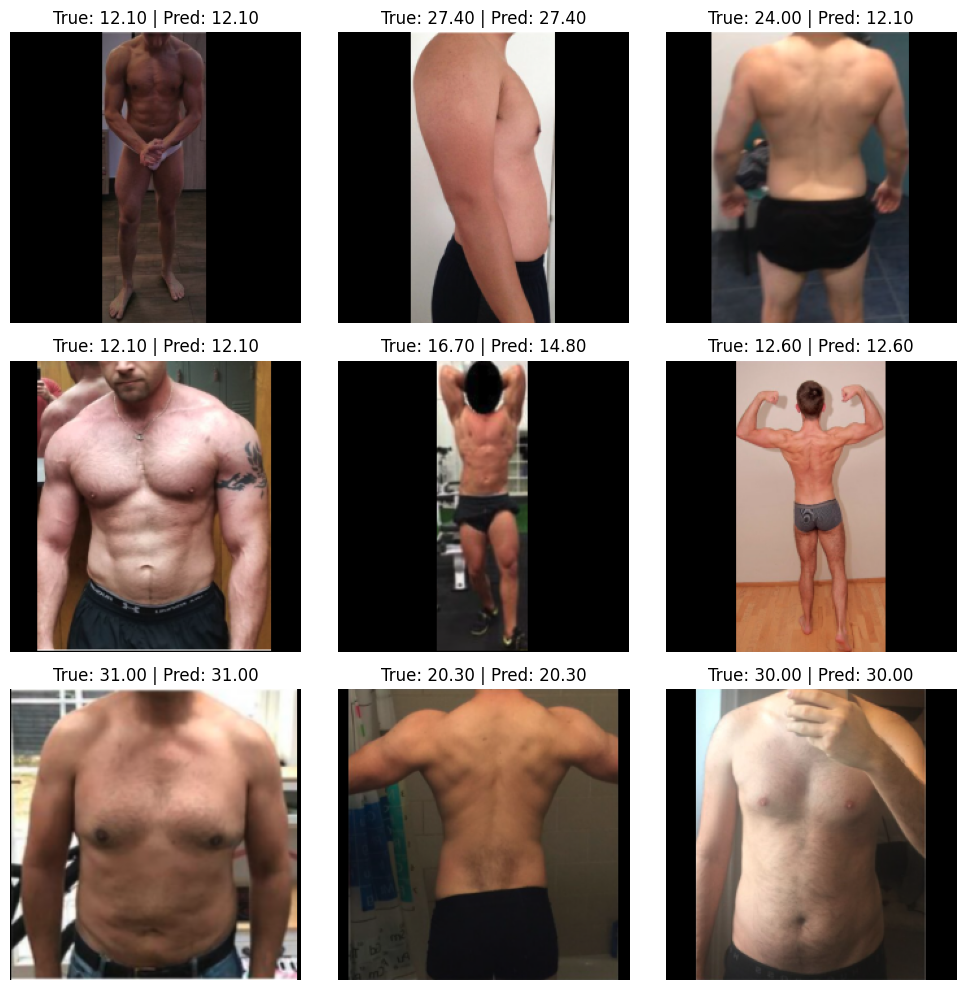

In [204]:
y_pred = tree.predict(X_test)

# Visualize predictions vs labels
plt.figure(figsize=(10, 10))
for i in range(min(9, len(imgs_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs_test[i])
    plt.title(f"True: {y_test[i]:.2f} | Pred: {y_pred[i]:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()